In [193]:
#Загрузим библиотеки
%matplotlib inline
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import datetime

Загрузим ивентлог.

In [194]:
df = pd.read_csv('Event_log.txt', sep='\t', encoding='cp1251')

In [195]:
def drop_unfinished(df):
    # Убирает незакрытые цепочки
    # Вход:  датафрейм
    # Выход: датафрейм, который содержит только закрытые цепочки
    
    # Подготавливаем два сета: первый содержит цепочки с категорией события 'Заказ на поставку создан', второй
    # содержит категорию события 'Платеж (выравнивание)'
    started_cases = set(df.iloc[np.where(df['Activity Category'] == 'Заказ на поставку создан')]['CaseID'])
    finished_cases = set(df.iloc[np.where(df['Activity Category'] == 'Платеж (выравнивание)')]['CaseID'])
    
    # Находим дополнение к пересечению этих множеств
    all_cases  = set(df['CaseID'].unique())
    ind = list(all_cases - (started_cases & finished_cases))
    
    
    # Убираем все кейсы из этого множества
    for case in ind:
        df = df.drop(df[df['CaseID'] == case].index)
    
    # Перенумерование индексов
    df = df.reset_index(drop = True)
    return df

In [196]:
df = drop_unfinished(df)

## P2P-метрики.

In [197]:
def P2P_1(df):
    
    # P2P-1 Объём закупок
    # будем запоминать кейсы которые мы уже посмотрели, чтобы не посчитать какой то кейс дважды
    visited_cases = []
    total_amount = 0
    
    # итерируемся по дата фрейму
    for i in range(len(df["CaseID"])):
        
        # Если кейс мы уже посетили, то переходим на следующий цикл итерации
        if(df["CaseID"][i] in visited_cases):
            continue
            
        # запоминаем кейс, в котором побывали
        visited_cases.append(df["CaseID"][i])
        
        # Проверяем не является ли переменная nan'ом
        if(not np.isnan(df["Amount"][i])):
                total_amount += df["Amount"][i]
    return total_amount

In [198]:
p2p_1 = P2P_1(df)

In [199]:
def P2P_2(df):
    
    # P2P-2 отношение количества товаров к количеству услуг
    cases = df['CaseID'].unique()
    
    # будем запоминать кейсы которые мы уже посмотрели, чтобы не посчитать какой то кейс дважды
    visited_cases = []
    services = 0
    goods = 0
    
    # Purchase_type[0] = 'Услуги', Purchase_type[1] = 'Товары'
    Purchase_type = df['Purchase type'].unique()
    
    # итерируемся по дата фрейму
    for i in range(len(df["CaseID"])):
        
        # Если кейс мы уже посетили, то переходим на следующий цикл итерации
        if(df["CaseID"][i] in visited_cases):
            continue
            
        # запоминаем кейс, в котором побывали
        visited_cases.append(df["CaseID"][i])
        if(df['Purchase type'][i] == Purchase_type[0]):
            services += 1
        else:
            goods += 1
            
    print(goods, services)
    return goods/services

In [200]:
p2p_2 = P2P_2(df)
p2p_2

3802 3511


1.0828823696952434

In [201]:
def P2P_3(df):
    
    # P2P-3 отношение трат на товары к тратам на услуги
    cases = df['CaseID'].unique()
    
    # будем запоминать кейсы которые мы уже посмотрели чтобы не посчитать какой то кейс дважды
    visited_cases = []
    services_total_amount = 0
    goods_total_amount = 0
    
    # Purchase_type[0] = 'Услуги', Purchase_type[1] = 'Товары'
    Purchase_type = df['Purchase type'].unique()
    for i in range(len(df["CaseID"])):
        
        # Если кейс мы уже посетили, то переходим на следующий цикл итерации
        if(df["CaseID"][i] in visited_cases):
            continue
            
        # Запоминаем кейс, в котором побывали
        visited_cases.append(df["CaseID"][i])
        if(df['Purchase type'][i] == Purchase_type[0]):
            
            # Проверяем не является ли переменная nan'ом
            if(not np.isnan(df["Amount"][i])):
                services_total_amount += df["Amount"][i]
        else:
            if(not np.isnan(df["Amount"][i])):
                goods_total_amount += df["Amount"][i]
    return (goods_total_amount/services_total_amount)

In [202]:
p2p_3 = P2P_3(df)
p2p_3

2.864576529450934

In [203]:
def P2P_4(df):
    
    # P2P-4 Процент товаров, которые поставляются исключительно внутренними поставщиками
    # Запоминаем все уникальные наименования товаров
    Material = list(df['Material'].unique())
    
    # Запоминаем сколько у нас было уникальных товаров
    quantity_of_mat = len(Material)
    total_amount_domestic_mat = 0
    
    for i in range(len(df["CaseID"])):
        
        # Проверяем встречали ли мы данный товар(если нет, то он будет в списке Material)
        if(df["Material"][i] in Material):
            
            # проверяем является ли поставщик внутренним
            if(df["Supplier_type"][i] == 'Внутренние'):
                total_amount_domestic_mat += 1
                
            # Удаляем данный товар из списка всех товаров (помечая что мы его проверили)
            Material.pop(Material.index(df["Material"][i]))
    return total_amount_domestic_mat

In [204]:
p2p_4 = P2P_4(df)

In [205]:
def P2P_5(df):
    # P2P-5 Количество неправильно завершенных частичных поставок
    # первый элемент вспомогательного списка это номер кейса затем активити из списка activ
    activ = ['Поступление материала-Возврат-Частичная поставка', 'Поступление материала-Получение-Завершающая поставка']
    quantity_of_wrong_cases = 0
    cases = df['CaseID'].unique()
    cases = list(cases)
    case_info = []
    
    # Создаём вспомогательный список
    for j in range(len(cases)):
        case_info.append([cases[j]])
    
    # находим индекс кейса в нашем списке (чтобы потом знать к какому элементу списка обращаться)
    for i in range(len(df["CaseID"])):
        case_index = cases.index(df['CaseID'][i])
        
        # запоминаем была ли частичная поставка в текущем кейсе
        if(df["Activity"][i] == activ[0]):
            case_info[case_index].append(activ[0])
        
        # запоминаем была ли завершающая поставка в текущем кейсе
        if(df["Activity"][i] == activ[1]):
            case_info[case_index].append(activ[1]) 
    for n in range(len(case_info)):
        
        # проверяем есть ли полная поставка после частичной
        if(activ[0] in case_info[n] and activ[1] not in case_info[n]):
            quantity_of_wrong_cases += 1
    return quantity_of_wrong_cases

In [206]:
p2p_5 = P2P_5(df)

In [207]:
def PrintTime(secs):
    
    # преобразуем всё в удобный нам формат дд:чч:мм:сс
    SECONDS_IN_DAY = 86400
    days = int(secs / SECONDS_IN_DAY) 
    sec = datetime.timedelta(seconds = (secs - days * SECONDS_IN_DAY))
    d = datetime.datetime(1,1,1) + sec
    
    # подбиравем правильные окончания для дней, часов, минут и секунд
    dayn = "days"
    hourn = "hours"
    minuten = "minutes"
    secondn = "seconds"
    
    if(days - 1 == 1):
        dayn = "day"
    elif(days >= 1 and days <= 4):
        dayn = "days"
    if(d.hour == 1 or d.hour == 21):
        hourn = "hour"
    elif((d.hour >= 2 and d.hour <= 4) or d.hour >= 22 and d.hour <= 24):
        hourn = "hours"
    if((d.minute % 10) == 1 and not d.minute == 11):
        minuten = "minute"
    elif((d.minute % 10) >= 2 and (d.minute % 10) <= 4 and not (d.minute >= 12 and d.minute <= 14)):
        minuten = "minutes"
    if((d.second % 10) == 1 and not d.second == 11):
        secondn = "second"
    elif((d.second % 10) >= 2 and (d.second % 10) <= 4 and not (d.second >= 12 and d.second <= 14)):
        secondn = "seconds"
        
    # возвращаем дату в формате дд:чч:мм:сс
    return "%s %s %s %s %s %s %s %s" % (days, dayn, d.hour, hourn, d.minute, minuten, d.second, secondn)

def P2P_6(df):
    
    # P2P-6 Среднее время подтверждения заказа
    cases = df['CaseID'].unique()
    cases = list(cases)
    case_time_list = []
    
    # Создаём вспомогательный список
    for i in range(len(cases)):
        case_time_list.append([cases[i], False])
    approved_times = []
    approved = ['Заказ на поставку согласован 1', 'Заказ на поставку согласован 2']
    
    # Сортриуем дфта фрейм
    df_time_sort = df.sort_values(by = 'Event end')
    
    # Перенумеровываем индексы
    df_time_sort = df_time_sort.reset_index(drop = True)
    
    # итерируемся с конца табоицы
    for j in range(len(df_time_sort) - 1, -1, -1):
        
        # находим индекс кейса в нашем списке
        case_index = cases.index(df_time_sort['CaseID'][j])
        
        # проверяем есть ли согласование заказа
        if(df_time_sort["Activity"][j] in approved and not case_time_list[case_index][1]): 
            
            # считаем время согласования
            try:
                
                # вычисляем время подтверждения заказа в секундах
                # предварительно задав формат даты как "%Y-%m-%d %H:%M:%S.%f"
                approved_time = time.mktime(time.strptime(str(df_time_sort['Event end'][j]), "%Y-%m-%d %H:%M:%S.%f"))
                
            # если по какой то причине формат был указан неверно (не оказалось миллисекунд),
            # то пытаемся посчитать время используя формат "%Y-%m-%d %H:%M:%S"
            except ValueError:
                approved_time = time.mktime(time.strptime(str(df_time_sort['Event end'][j]), "%Y-%m-%d %H:%M:%S"))
            
            # запоминаем время подтверждения
            case_time_list[case_index].append(approved_time)
            
            # помечаем, что для данного кейса время уже рассчитано (так как нам нужно время только послежнего подтверждения)
            case_time_list[case_index][1] = True
            
        # проверяем время создания заказа и считаем его    
        if(df_time_sort["Activity"][j] == 'Заказ на поставку создан'):
            try:
                
                # вычисляем время сохдания заказа в секундах
                # предварительно задав формат даты как "%Y-%m-%d %H:%M:%S.%f"
                starting_time = time.mktime(time.strptime(str(df_time_sort['Event end'][j]), "%Y-%m-%d %H:%M:%S.%f"))
                
            # если по какой то причине формат был указан неверно (не оказалось миллисекунд),
            # то пытаемся посчитать время используя формат "%Y-%m-%d %H:%M:%S"    
            except ValueError:
                starting_time = time.mktime(time.strptime(str(df_time_sort['Event end'][j]), "%Y-%m-%d %H:%M:%S"))
            case_time_list[case_index].append(starting_time)
    cases_without_confirm = 0
    
    # отнимаем время согласования и создания заявки у всех кейсов
    for n in range(len(case_time_list)):
        if(len(case_time_list[n]) == 4):
            approved_times.append(case_time_list[n][2] - case_time_list[n][3])
        if(len(case_time_list[n]) == 3):
            cases_without_confirm += 1
    
    # если не было найдено ни одного заказа с подтверждением, то возвращаем ноль
    if(len(approved_times) == 0):
        return 0
    else:
        
        # возвращаем список состоящий из
        # среднего времени согласования заказов в формате дд:чч:мм:сс
        # Процентф кейсов без согласования
        # Процентф согласованных кейсов
        return [PrintTime(sum(approved_times)/len(approved_times)),
                round(cases_without_confirm/(cases_without_confirm + len(approved_times)) * 100),
                round(len(approved_times)/(cases_without_confirm + len(approved_times)) * 100)]

In [208]:
p2p_6 = P2P_6(df)

In [209]:
def P2P_7(df):
    
    # P2P-7 Среднее количество изменений заказа
    cases = df['CaseID'].unique()
    
    # changes это список в котором хранятся все события, которые считаются изменением заказа
    changes = ['Заказ на поставку бессрочно заблокирован', 'Заказ на поставку изменен: лимит на недопоставку', 
             'Заказ на поставку изменен: группа закупки', 'Заказ на поставку изменен: лимит на сверх-поставку',
             'Заказ на поставку изменен: материал', 'Заказ на поставку изменен: налоговые условия',
             'Заказ на поставку изменен: запланированный срок доставки в днях', 
              'Заказ на поставку изменен: эффективная стоимость', 'Заказ на поставку изменен: уменьшена стоимость',
             'Заказ на поставку изменен: уменьшена цена', 'Заказ на поставку изменен: уменьшено количество',
             'Заказ на поставку изменен: увеличена стоимость', 'Заказ на поставку изменен: увеличено количество',
             'Заказ на поставку изменен: увеличена цена', 'Заказ на поставку изменен: срока предоставления скидки',
             'Заказ на поставку изменен: условия оплаты', 'Заказ на поставку изменен: завод', 
              'Заказ на поставку изменен: статус наличия счета', 'Заказ на поставку изменен: валюта',
             'Заказ на поставку изменен: поставщик', 'Заказ на поставку изменен: тип документа']
    quantity_of_changes = 0
    visited_cases = []
    for i in range(len(df["CaseID"])):
        # проверяем считается ли данное событие изменением заказа
        if(df["Activity"][i] in changes):
            quantity_of_changes += 1
            
            # если мы нашили изменение заказа в текущем кейсе, то помечаем его как кейс, в котором были изменения заказа
            if(df["CaseID"][i] not in visited_cases):
                visited_cases.append(df["CaseID"][i])
    return [quantity_of_changes/len(cases), len(visited_cases)]

In [210]:
p2p_7 = P2P_7(df)

In [211]:
def P2P_8(df):
    
    # P2P-8 Поставщики с высоким уровнем возвратов
    # первый элемент вспомогательного массива suppliers_info это сам поставщик, второй это количество возвратов у этого поставщика
    # третьий это количество заказов, которые были сделаны у данного поставщика, четвёртый это взвешенное среднее после этого
    # идёт список кейсов, в которых присутствовал данный поставщик пример: ["seller of cars", 10, 40, 2.4, case12, case45, ...]
    cases = df['CaseID'].unique()
    suppliers_info = []
    
    # список всех поставщиков
    suppliers = list(df["Supplier"].unique())
    for i in range(len(suppliers)):
        
        # Создаём вспомогательный массив
        suppliers_info.append([suppliers[i], 0, 0, 0])
    for j in range(len(df)):
        
        # находим индекс поставщика в нашем списке
        supplier_index = suppliers.index(df["Supplier"][j])
        
        # проверяем был ли возврат
        if(df["Activity Category"][j] == "Поступление материала-Возврат"):
            suppliers_info[supplier_index][1] += 1 
            
        # проверяем смотрели ли мы этот кейс для данного поставщика
        if(df["CaseID"][j] not in suppliers_info[supplier_index]):
            suppliers_info[supplier_index][2] += 1
            suppliers_info[supplier_index].append(df["CaseID"][j])
    
    # ищем поставщика с максимальным количеством заказов
    maximum_orders = 0
    for n in range(len(suppliers_info)):
        if(maximum_orders < suppliers_info[n][2]):
            maximum_orders = suppliers_info[n][2]
    
    # считаем взвешенное среднее для каждого поставщика
    for r in range(len(suppliers_info)):
        if(maximum_orders == suppliers_info[r][2]):
            suppliers_info[r][3] = suppliers_info[r][1]/((maximum_orders + 1) - suppliers_info[r][2])
            continue
        suppliers_info[r][3] = suppliers_info[r][1]/(maximum_orders - suppliers_info[r][2])

    # сортируем всё по взвешенному среднему
    suppliers_info.sort(key = lambda x: x[3], reverse = True)
    quantity_of_danger_sup = 0
    danger_suppliers = []
    mean_weight = suppliers_info[0][3]/2
    
    # проверяем сколько постващиков имеют высокий уровень возвратов
    for g in range(len(suppliers_info)):
        if(suppliers_info[g][3] > mean_weight):
            quantity_of_danger_sup += 1
            danger_suppliers.append(suppliers_info[g][0])
        else:
            break
    return quantity_of_danger_sup

In [212]:
p2p_8 = P2P_8(df)

In [213]:
def P2P_9(df):
    
    # P2P-9 Процент заказов у поставщиков с высоким уровнем возвратов
    # первый элемент вспомогательного массива suppliers_info это сам поставщик, второй это количество возвратов у этого поставщика
    # третьий это количество заказов, которые были сделаны у данного поставщика, четвёртый это взвешенное среднее после этого
    # идёт список кейсов, в которых присутствовал данный поставщик пример: ["seller of cars", 10, 40, 2.4, case12, case45, ...]
    cases = df['CaseID'].unique()
    suppliers_info = []
    
    # список всех поставщиков
    suppliers = list(df["Supplier"].unique())
    for i in range(len(suppliers)):
        
        # Создаём вспомогательный массив
        suppliers_info.append([suppliers[i], 0, 0, 0])
    for j in range(len(df)):
        
        # находим индекс поставщика в нашем списке
        supplier_index = suppliers.index(df["Supplier"][j])
        
        # проверяем был ли возврат
        if(df["Activity Category"][j] == "Поступление материала-Возврат"):
            suppliers_info[supplier_index][1] += 1 
            
        # проверяем смотрели ли мы этот кейс для данного поставщика
        if(df["CaseID"][j] not in suppliers_info[supplier_index]):
            suppliers_info[supplier_index][2] += 1
            suppliers_info[supplier_index].append(df["CaseID"][j])
    
    # ищем поставщика с максимальным количеством заказов
    maximum_orders = 0
    for n in range(len(suppliers_info)):
        if(maximum_orders < suppliers_info[n][2]):
            maximum_orders = suppliers_info[n][2]
    
    # считаем взвешенное среднее для каждого поставщика
    for r in range(len(suppliers_info)):
        if(maximum_orders == suppliers_info[r][2]):
            suppliers_info[r][3] = suppliers_info[r][1]/((maximum_orders + 1) - suppliers_info[r][2])
            continue
        suppliers_info[r][3] = suppliers_info[r][1]/(maximum_orders - suppliers_info[r][2])

    # сортируем всё по взвешенному среднему
    suppliers_info.sort(key = lambda x: x[3], reverse = True)
    quantity_of_danger_sup = 0
    danger_suppliers = []
    mean_weight = suppliers_info[0][3]/2
    
    # проверяем сколько постващиков имеют высокий уровень возвратов
    for g in range(len(suppliers_info)):
        if(suppliers_info[g][3] > mean_weight):
            quantity_of_danger_sup += 1
            danger_suppliers.append(suppliers_info[g][0])
        else:
            break
    
    # считаем количество заказов у поставщиков с высоким уровнем возвратов
    vis_cases = []
    n = 0
    quantity_of_danger_orders = 0
    for i in range(len(df["CaseID"])):
        
        # проверяем посещали ли мы текущий кейс
        if(df["CaseID"][i] not in vis_cases):
            
            # проверяем является ли текущий поставщик поставщиком с высоким уровнем возвратов, если да, то увеличиваем
            # счётчик quantity_of_danger_orders на единицу
            if(df['Supplier'][i] in danger_suppliers):
                quantity_of_danger_orders += 1
            
            # запоминаем, что этот кейс мы уже посетили
            vis_cases.append(df["CaseID"][i])
    return round(quantity_of_danger_orders/len(cases) * 100)

In [214]:
p2p_9 = P2P_9(df)

In [215]:
def P2P_10(df):
    
    # P2P-10 Оборотный капитал: издержки возвратов
    suppliers = df['Supplier'].unique()
    suppliers = list(suppliers)
    suppliers_list = []
    cases_summed = []
    
    # первый элемент вспомогательного списка suppliers_list это имя поставщика, второй это сумма всех возвратов, третий количество возвратов
    # и четвёртый это общее количество заказов
    # создаём вспомогательный список
    for i in range(len(suppliers)):
        suppliers_list.append([suppliers[i], 0, 0, 0])
        
    for j in range(len(df["CaseID"])):
        
        # находим индекс кейса в нашем списке
        supplier_index = suppliers.index(df['Supplier'][j])
        if(df['CaseID'][j] not in suppliers_list[supplier_index]):
            
             # помечаем кейс для данного поставщика
            suppliers_list[supplier_index].append(df['CaseID'][j])
            
            # увеличиваем счётчик количества заказов для данного поставщика
            suppliers_list[supplier_index][3] += 1
            
        if(df['Activity Category'][j] == 'Поступление материала-Возврат'):
            if(df['CaseID'][j] not in cases_summed):
                if(not np.isnan(df["Amount"][j])):
                    
                    # увеличиваем счётчик суммы возвратов
                    suppliers_list[supplier_index][1] += df["Amount"][j]
                    
                # запоминаем посещённый кейс
                cases_summed.append(df['CaseID'][j])
                
                # увеличиваем счётчик количество возвратов
                suppliers_list[supplier_index][2] += 1
    expec = 0
    
    # считаем вероятность возврата и умножаем это на сумму возвратов, затем суммируем эти значения по всем поставщикам
    for n in range(len(suppliers_list)):
        
        # вероятность возврата умноженная на сумму
        expec += suppliers_list[n][2]/suppliers_list[n][3] * suppliers_list[n][1]
    return expec

In [216]:
p2p_10 = P2P_10(df)

Подготовим ивентлог для дальнейшей работы:
1. Преобразуем колонку "Event end" в тип *datetime*
2. Зададим порядок на событиях.
3. Отсортируем ивентлог сначала по временной отметке ("Event end"), а затем, в случае равенства времени, отсортируем события ("Activity") по заданному ранее порядку.

In [217]:
#1
df = pd.read_csv('Event_log.txt', sep='\t', encoding='cp1251')
df['Event end'] = pd.to_datetime(df['Event end'])

In [218]:
#2 - порядок: 
#https://docs.google.com/spreadsheets/d/16JxSRbvITYWgG_ov5JRpdduzbPC4-THgZwN7RiskkgM/edit?hl=en#gid=737381414

order = ['Создание Заявки',
         'Заявка согласована',
         'Заявка изменена: дата доставки',
         'Заявка изменена: закупочная организация',
         'Заявка изменена: количество',
         'Заявка изменена: увеличена цена',
         
         'Заказ на поставку создан',
         
         'Требование авансового платежа',
         'Требование авансового платежа-Возврат',
         'Авансовый платеж',
         'Перерасчет по требованию авансового платежа',
         'Перерасчет авансового платежа',
         'Перерасчет авансового платежа-Возврат',
         
         'Заказ на поставку изменен: валюта',
         'Заказ на поставку изменен: налоговые условия',
         'Заказ на поставку изменен: срока предоставления скидки',
         'Заказ на поставку изменен: условия оплаты',
         'Заказ на поставку изменен: увеличено количество',
         'Заказ на поставку изменен: уменьшено количество',
         'Заказ на поставку изменен: увеличена цена',
         'Заказ на поставку изменен: уменьшена цена',
         'Заказ на поставку изменен: увеличена стоимость',
         'Заказ на поставку изменен: уменьшена стоимость',
         'Заказ на поставку изменен: эффективная стоимость',
         'Заказ на поставку изменен: группа закупки',
         'Заказ на поставку изменен: завод',
         'Заказ на поставку изменен: запланированный срок доставки в днях',
         'Заказ на поставку изменен: лимит на недопоставку',
         'Заказ на поставку изменен: лимит на сверх-поставку',
         'Заказ на поставку изменен: материал',
         'Заказ на поставку изменен: поставщик',
         'Заказ на поставку изменен: статус наличия счета',
         'Заказ на поставку изменен: тип документа',
         
         'Заказ на поставку согласован 1',
         'Заказ на поставку: изменен статус выпуска: ДанныеОтпр, возможны изменения',
         'Заказ на поставку: изменен статус выпуска: НачКод, возможны изменения',
         'Заказ на поставку: изменен статус выпуска: ДанныеСогл, измен не возможны',
         'Заказ на поставку: изменен статус выпуска: Согл, измен не возможны',
         'Заказ на поставку согласован 2',
         
         'Заказ на поставку: согласование отклонено',
         'Заявка: согласование отклонено',
         'Заказ на поставку бессрочно заблокирован',
         'Заказ на поставку удален',
         'Заявка удалена',
         'Заявка восстановлена',
         'Заказ на поставку восстановлен',
         
         'Поступление материала-Получение-Завершающая поставка',
         'Поступление материала-Получение-Частичная поставка',
         'Поступление материала-Возврат-Частичная поставка',
         'Поступление материала-Возврат-Завершающая поставка',
         
         'Счет предварительно полностью зарегистрирован',
         'Счет заведен',
         'Поступление счета',
         'Поступление счета-Возврат',
         
         'Счет блокирован: несоответствие даты',
         'Счет блокирован: несоответствие количества',
         'Счет блокирован: несоответствие цены',
         'Счет изменен: налоговые условия',
         'Счет изменен: условия оплаты',
         'Счет изменен: дата',
         
         'Платеж (выравнивание)',
         
         'Ведомость учета работ/услуг']

In [219]:
#3

df['Activity'] = pd.Categorical(df['Activity'], categories=order)
df = df.sort_values(by=['Event end', 'Activity'])

## KPI

На вход подается объект - dataframe, **отсортированный по временной отметке и событиям**.

### Общие.

1) О-1 Общее количество экземпляров процесса (кейсов). +

2) О-2 Количество маршрутов. (- время работы) +-

UPD: вывожу сам словарь, массив, в котором хранится последовательность событий для фиксированного маршртуа, а также массив с "Case Id" экземпляров процесса соответствующих маршрутам. Это выводится для того, чтобы считать O-5 и O-7 по маршрутам.

3) О-3 Количество уникальных пользователей. +

4) О-4 Число начатых и завершившихся экземпляров процесса. +

UPD: вывожу число и процент. 

5) О-5 Нестандартные по времени экземпляры процесса. +

UPD: смотрю по маршрутам.

Для двух стандартных отклонений вывод: (252, 0.031401869158878506).

Для одного: (868, 0.1081619937694704).

Больше среднего: (2411, 0.30043613707165107).

6) О-6 Сложные экземпляры процесса. (на доработке)

7) О-7 Среднее количество циклов на экземпляр процесса.

UPD: убираю клиринг.

Считаю по маршрутам.

Проблема: 

8) О-8 Среднее количество экземпляров процесса, созданных за один день. +

UPD: построил горизонтальную гистограмму. 

Проблема: слишком много значений. 

Возможное решение: брать лишь некоторые значения для визуализации, например, которые сильно отклонялись от среднего.

9) О-9 Самые популярные категории событий. +

UPD: считаю популярность не по событиям, а по экземплярам процесса, которые были охвачены категорией.

10) О-10 Среднее количество времени, проведенное в рамках одного класса событий. +

UPD: Перевел вывод в формат Дни:Часы:Минуты:Секунды. Изменил общее на среднее.

In [220]:
def unique_paths(df):
    #Считает количество маршрутов.
    
    #Вход:  dataframe - eventlog, отсортированный по временной отметке и событиям. 
    #Выход: количество маршрутов.
    
    cases = df['CaseID'].unique()
    chain = df[df['CaseID'] == cases[0]]
    activ = chain['Activity'].tolist()

    eq_chains = []
    eq_chains.append(activ)

    num_cases = [[] for i in range(len(cases))]
    num_cases[0].append(cases[0])

    d = {}
    d[0] = 1
    k = 1

    for case in cases[1:]:
        chain = df[df['CaseID'] == case]
        activ = chain['Activity'].tolist()
        i = 0
    
        for key in d.keys():
            if eq_chains[key] == activ:
                d[key] += 1
                num_cases[key].append(case)
                break
            i += 1
        if i == k:
            d[k] = 1
            eq_chains.append(activ)
            num_cases[k].append(case)
            k += 1
            
    return d, eq_chains, num_cases

In [221]:
tran_dict = {'Авансовый платеж': 'Upfront payment' , 
 'Авансовый платеж-Возврат': 'Upfront payment-return', 
 'Заказ на поставку':'Order for a delivery', 
 'Заказ на поставку восстановлен': 'Order for a delivery restored', 
 'Заказ на поставку изменен': 'Order for a delivery changed', 
 'Заказ на поставку отклонен': 'Order for a delivery declined',
 'Заказ на поставку согласован': 'Order for a delivery agreed',
 'Заказ на поставку создан': 'Order for a delivery created',
 'Заказ на поставку удален': 'Order for a delivery deleted', 
 'Заявка': 'Request', 
 'Заявка восстановлена': 'Request restored',
 'Заявка изменена': 'Request changed', 
 'Заявка отклонена': 'Request declined',
 'Заявка согласована': 'Request agreed',
 'Заявка удалена': 'Request deleted', 
 'Перерасчет авансового платежа': 'recalculation of upfront payment',
 'Платеж (выравнивание)': 'Payment (clearing)', 
 'Поступление материала': 'Product delivery',
 'Поступление материала-Возврат': 'Product delivery-Return', 
 'Поступление материала-Получение': 'Product delivery - Recieved',
 'Поступление счета': 'Invoice recieved', 
 'Поступление счета-Возврат': 'Invoice recieved-return',
 'Создание Заявки':'Creation of a request', 
 'Статус счета изменен': 'Status of an invoice changed',
 'Счет': 'Account',
 'Счет блокирован': 'Account blocked', 
 'Счет изменен': 'Account changed', 
 'Учет услуг': 'Accounting services'}

#### 1. О-1 Общее количество экземпляров процесса (кейсов).

In [222]:
def O_1(df):
    #Вычисляет общее количество экземпляров процесса .
    
    #Вход:  dataframe - eventlog, отсортированный по временной отметке и событиям.
    #Выход: общее количество цепочек.
    
     return len(df['CaseID'].unique())

In [223]:
#time check
%time O_1(df)

Wall time: 10.9 ms


8025

#### 2. О-2 Количество маршрутов.

In [224]:
#считает словарь ключ - уникальная цепочка, значение - количество повторений, т.е. сразу считает "гистрограмму"
#популярности цепочек
#замечание! медленно работает - ускорить

# eq_chains - события одного маршрута
# num_cases - CaseID цепочек, которые входят в маршрут
# d - словарь, в котором ключ - номер маршрута, значение - количество цеопчек этого маршрута 
# k - сколько всего маршрутов на текущий момент
# i - число для проверки того, прошли ли мы все значения словря за итерацию

def O_2(df):
    #Считает количество маршрутов.
    
    #Вход:  dataframe - eventlog, отсортированный по временной отметке и событиям. 
    #Выход: количество маршрутов.
    
    cases = df['CaseID'].unique()
    chain = df[df['CaseID'] == cases[0]]
    activ = chain['Activity'].tolist()

    eq_chains = []
    eq_chains.append(activ)

    num_cases = [[] for i in range(len(cases))]
    num_cases[0].append(cases[0])

    d = {}
    d[0] = 1
    k = 1

    for case in cases[1:]:
        chain = df[df['CaseID'] == case]
        activ = chain['Activity'].tolist()
        i = 0
    
        for key in d.keys():
            if eq_chains[key] == activ:
                d[key] += 1
                num_cases[key].append(case)
                break
            i += 1
        if i == k:
            d[k] = 1
            eq_chains.append(activ)
            num_cases[k].append(case)
            k += 1
            
 #   return d, eq_chains, num_cases
    return len(d)

In [225]:
%time O_2(df)

Wall time: 1min 34s


1653

#### 3. О-3 Количество уникальных пользователей.

In [226]:
def O_3(df):
    #Вход:  dataframe - eventlog, отсортированный по временной отметке и событиям.
    #Выход: количество уникальных пользователей.
    user_dict = df.groupby('User')['Activity'].count().to_dict()

    plt.figure(figsize=(15, 25)) 
    plt.barh(range(len(user_dict)), list(user_dict.values()), align='center')
    plt.yticks(range(len(user_dict)), list(user_dict.keys()))
    plt.show()
    
    return len(df['User'].dropna().unique())

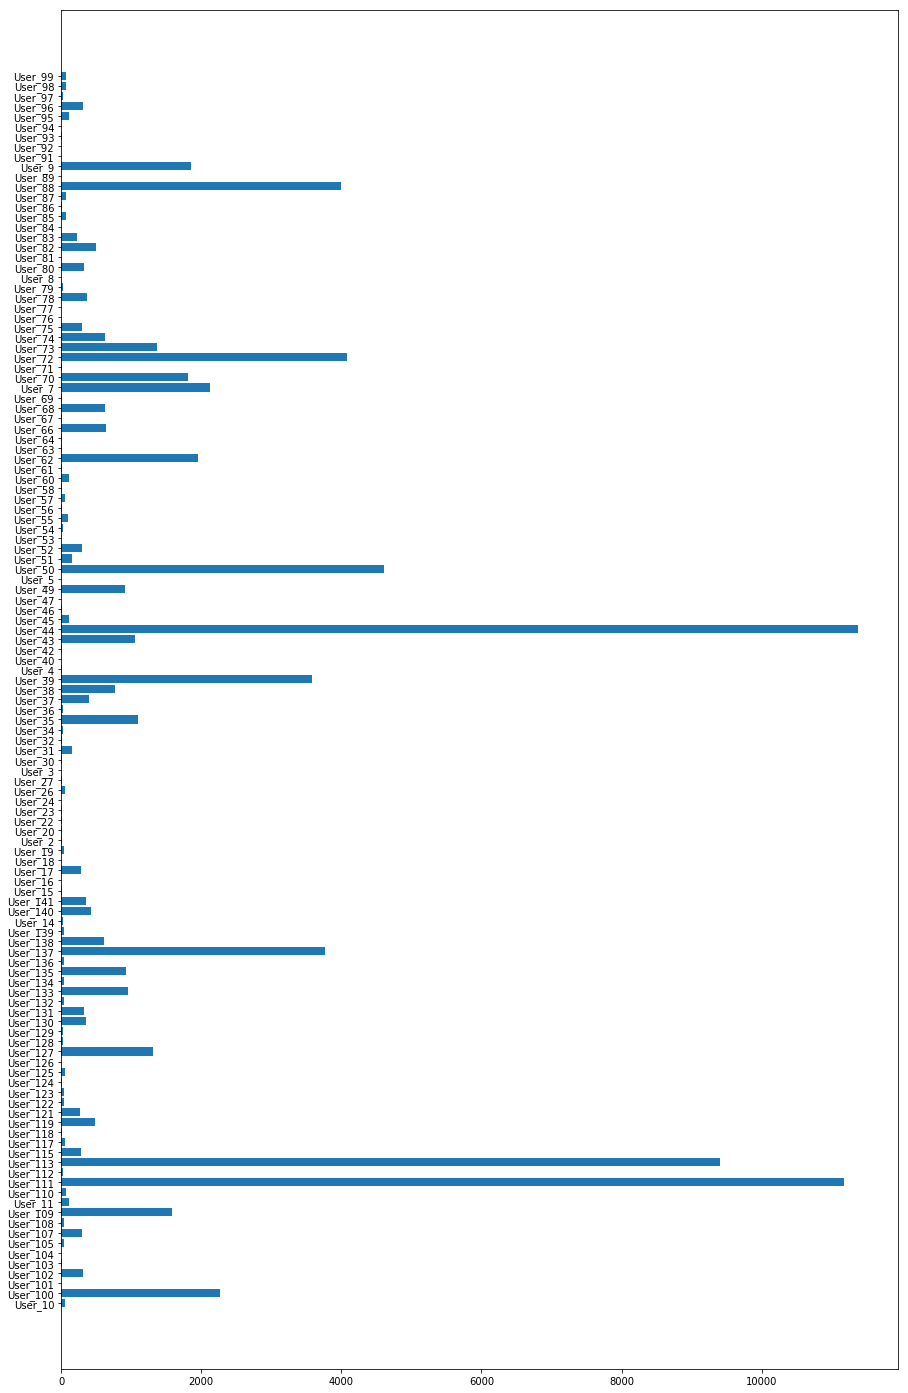

Wall time: 2.24 s


123

In [227]:
#time check
%time O_3(df)

#### 4. О-4 Число начатых и завершившихся экземпляров процесса.

In [228]:
def O_4(df):
    #Считает число начатых и законченных экземпляров процесса (кейсов) и их долю от общего числа экземпляров процесса.
    
    #Вход:  dataframe - eventlog, отсортированный по временной отметке и событиям.
    #Выход: число и отношение кол-ва начатых и завершенных экземпляров процесса (кейсов)
    #       (т.е. таких экземпляров процесса (кейсов), которые закончились Катагорией События
    #       ('Activity Category') == 'Платеж (выравнивание)') к общему кол-ву экземпляров процесса.
    
    started_cases = set(df.iloc[np.where(df['Activity Category'] == 'Заказ на поставку создан')]['CaseID'])
    finished_cases = set(df.iloc[np.where(df['Activity Category'] == 'Платеж (выравнивание)')]['CaseID'])
    
    return len(started_cases & finished_cases), len(started_cases & finished_cases) / len(df['CaseID'].unique())

In [229]:
#time check
%time O_4(df)

Wall time: 36.9 ms


(7313, 0.9112772585669782)

#### 5. О-5 Нестандратные по времени экземпляры процесса (кейсы).

In [230]:
def O_5(df):
    # Вычисляет нестандартные экземпляры процесса (кейсы) по времени в рамках маршрутов.
    # Нестандартная экземпляр процесса - экземпляр процесса, который отклоняется по времени от среднего
    # более чем на два стандартных отклонения.
    
    # Вход:  dataframe-eventlog, отсортированный по временной отметке и событиям.
    # Выход: кортеж(tuple). 
    #        Первое значение - количество нестандартных по времени экземпляров процесса.
    #        Второе значение - процентное соотношение этих экземпляров процесса ко всем экземплярам процесса.
    
    cases = df['CaseID'].unique()
    all_time = df.groupby(
        ['CaseID'])['Event end'].apply(
        lambda a: (a.max() - a.min()).total_seconds()
    )
    
    d, eq_chains, num_cases = unique_paths(df)
    ind = 0
    anomal_cases = []
    
    for i in range(len(num_cases)): 
        c = num_cases[i]
        av = np.mean(all_time[c])
        std = np.std(all_time[c])
        to_remember = np.where(all_time[c] > av + 2 * std)[0]
        
        if len(to_remember) != 0:
            anomal_cases.append(num_cases[i])
        ind += len(to_remember)
    
    return ind, ind / len(cases), anomal_cases

In [231]:
#time check
#%time O_5(df)

#### 6. О-6 Сложные экземпляры процесса.

In [232]:
def convert_to_adj_list(activ):
    #Переводит из последовательности событий в список смежности.(более удобное представление графа).
    
    #Вход:  activ - list, массив строк - последовательность событий одного экземпляра процесса.
    #Выход: res - list, массив смежности графа.
    decode = list(set(activ))
    dec_dict = {}
    
    for i in range(len(decode)):
        dec_dict[decode[i]] = i
    
    res = [[] for i in range(len(decode))]
    
    for i in range(len(activ) - 1):
        res[dec_dict[activ[i]]].append(dec_dict[activ[i + 1]])
    
    return res

def O_6(df):
    #Считает количество сложных экземплярлв процесса. Сложный экземпляр процесса - такой экземпляра процесса, 
    #который отклоняется от среднего больше, чем на одно стандартное отклонение,
    #по количеству событий и количеству циклов. 
    
    #Вход:  dataframe-eventlog, отсортированный по временной отметке и событиям.
    #Выход: количество сложных экземпляров процесса.
 
    num_of_act_in_case = df.groupby('CaseID').agg({'Activity': 'count'})['Activity'].to_dict()
    
    num_of_loop_in_case = {}

    cases = df['CaseID'].unique()
    begin = time.time()
    for case in cases:
        chain = df.iloc[np.where(df['CaseID'] == case)]
        activ = chain['Activity'].tolist()
    
        l_am = 0
    
        if len(activ) != len(set(activ)):
 
            conv_activ = convert_to_adj_list(activ)
            visited = [0 for i in range(len(conv_activ))]
        
            def dfs(vert, l_am):
                #Обход в глубину.
                visited[vert] = 1
                for v in conv_activ[vert]:
                    if not visited[v]:
                        l_am = dfs(v, l_am)
                    else:
                        l_am += 1
                return l_am

            for i in range(len(conv_activ)):
                if not visited[i]:
                    l_am += dfs(i, l_am)

        num_of_loop_in_case[case] = l_am
        
    loop_in_case = np.array(list(num_of_loop_in_case.values()))
    act_in_case = np.array(list(num_of_act_in_case.values()))
    
    av_loop = np.mean(loop_in_case)
    std_loop = np.std(loop_in_case) 
    ind_loop = np.where(loop_in_case > av_loop + std_loop)

    av_act = np.mean(act_in_case)
    std_act = np.std(act_in_case)
    ind_act = np.where(act_in_case > av_act + std_act)
    
    return len(set(ind_act[0]) & set(ind_loop[0]))

In [233]:
#time check
#%time O_6(df)

#### 7. О-7 Среднее количество циклов на один экземпляр процесса.

In [234]:
def O_7(df):
    #Смотреть по маршрутам. 
    #без клиринга
    
    #Вычисляет среднее количество циклов на один экземпляр процесса.
    
    #Вход:  dataframe - eventlog, отсортированный по временной отметке и событиям.
    #Выход: среднее количество циклов на один экземпляр процесса.
    
    n_df = df.drop(df[df['Activity'] == 'Платеж (выравнивание)'].index)
    
    cases = n_df['CaseID'].unique()    
    loops = []
    ind = {}
    i = 0
    
    for case in cases:
        chain = n_df[n_df['CaseID'] == case]
        activ = chain['Activity'].tolist()
        ind[case] = i
        
        events = set()
        loop_am = 0
        
        for act in activ:
            if act in events:
                loop_am += 1
                events.add(act)
            else:
                events.add(act)
        
        i += 1        
        loops.append(loop_am)
        
   
    d, eq_chains, num_cases = unique_paths(n_df)
    av = []
        
    loops = np.array(loops)
    
    for c in num_cases: 
        summ = 0
        count = 0
        for j in c:
            summ += ind[j]
            count += 1
            
        if count:
            av.append(summ / count)
        else:
            av.append(0)
    
    return np.array(av).mean()

In [235]:
#time check
#%time O_7(df)

#### 8. О-8 Среднее количество экземпляров процесса, созданных за один день.

In [236]:
import matplotlib.pyplot as plt

def O_8(df):
    #Вычисляет среднее количество экземпляров процесса, созданных за день.
    #(т.е. таких, у которых Событие('Activity') == 'Заказ на поставку создан')
    
    #Вход:  dataframe - eventlog, отсортированный по временной отметке и событиям.
    #Выход: среднее количество экземпляров процесса, созданных за день.
    
    df_n = pd.DataFrame(df, columns=['Event end', 'CaseID', 'Activity'])
    df_n['Event end'] = df_n['Event end'].astype(str).apply(lambda x: x[:10])
    count = df_n.iloc[np.where(df_n['Activity'] == 'Заказ на поставку создан')]['Event end']
    
    plt.figure(figsize=(25, 10))
    plt.title('Распределние создания экземпляров процесса по неделям')
    plt.xlabel('Дата')
    plt.ylabel('Количество созданий')
    plt.hist(pd.to_datetime(count.values), bins=52, alpha=0.78)
    plt.show()
    
    am = sum(Counter(count).values())
    days = len(df_n['Event end'].unique())
    
    return am / days

In [237]:
#time check
#%time O_8(df)

#### 9. О-9 Самые популярные категории событий.

In [238]:
def O_9(df):
    #Вычисляет популярные категории событий относительно количества экземпляров процесса и пользователей.
    
    #Вход:  dataframe - eventlog, отсортированный по временной отметке и событиям.
    #Выход: Кортеж (act_am_dict, users_am_dict) 
    #        act_am_dict - словарь, в котором ключ - название категории событий('Activity Category'),
    #        а значение - отношение количества экземпляров процесса, которые охвачены категорией, 
    #        и количества всех экземпляров процесса.
    #        users_am_dict - словарь, в котором ключ - название категории событий('Activity Category'),
    #        а значение - количество уникальных пользователей, которые участвовали в этой категории событий.
    
    df_n = df.drop(df[df['Activity Category'] == 'Платеж (выравнивание)'].index)
    act_am_dict = df_n.groupby('Activity Category')['CaseID'].unique().apply(lambda x: len(x))\
                  .div(len(df_n['CaseID'].unique())).to_dict()
    users_am_dict = df_n.groupby('Activity Category').agg({"User": lambda x: x.nunique()}).to_dict()['User']
    sorted_act_am_dict = sorted(act_am_dict.items(), key=lambda kv: kv[1], reverse=True)
    sorted_users_am_dict = sorted(users_am_dict.items(), key=lambda kv: kv[1], reverse=True)
    
    ret_first = []
    ret_second = []
    
    for i in range(5):
        key_1 = sorted_act_am_dict[i]
        key_2 = sorted_users_am_dict[i]
        
        ret_first.append([tran_dict[key_1[0]], key_1[1]])
        ret_second.append([tran_dict[key_2[0]], key_2[1]])
        
    return ret_first, ret_second

In [239]:
#time check
#%time O_9(df)

#### 10. О-10 Среднее количество времени, проведенное в рамках одного класса событий.

In [240]:
def convert_time(time):
    
    day = time // (24 * 3600)
    time = time % (24 * 3600)
    hour = time // 3600
    time %= 3600
    minutes = time // 60
    time %= 60
    seconds = time
    
    return "%d Days %d Hours %d Minutes %d Seconds" % (day, hour, minutes, seconds)

def O_10(df):
    #Вычисляет отношение общего времени, проведенного в рамках категории события, к количеству экземпляров процесса,
    #которые были охвачены этой категорией события.
    
    #Вход:  dataframe - eventlog,  отсортированный по временной отметке и событиям.
    #Выход: all_time - словарь, где ключ - название категории события, а значение - среднее количество проведенного 
    #       времени в рамках соотв. категории события на экземпляр события.
    df.sort_values(by='Event end', inplace=True)
    all_time = {cat : 0 for cat in df['Activity Class'].unique()}
    case_am = {cat : 0 for cat in df['Activity Class'].unique()}
    cases = df['CaseID'].unique()
    
    
    for case in cases:
        chain = df.iloc[np.where(df['CaseID'] == case)]
        cat = chain['Activity Class'].tolist()
        time = chain['Event end'].tolist()
        
        for i in range(len(cat) - 2):
            all_time[cat[i]] += (time[i + 1] - time[i]).total_seconds()
        
        for cl in cat:
            case_am[cl] += 1
    ret = []
    for key in all_time.keys():
        all_time[key] = convert_time((all_time[key] / case_am[key]))
        ret.append([tran_dict[key], all_time[key]])
        
    return ret 

In [241]:
#%time O_10(df)

In [242]:
o_1 = O_1(df)

In [243]:
o_2 = O_2(df)

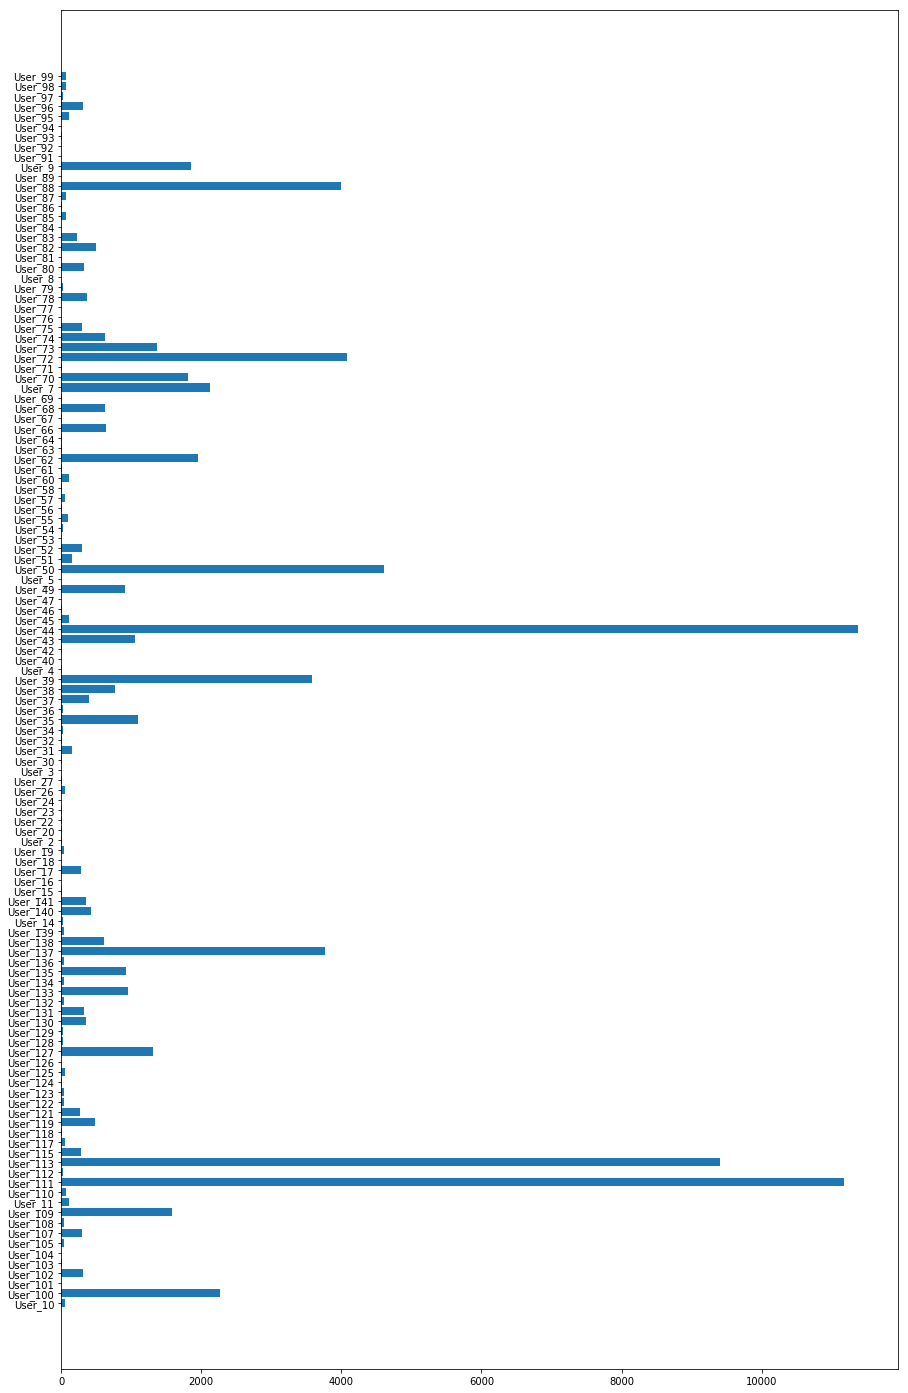

In [244]:
o_3 = O_3(df)

In [245]:
o_4 = O_4(df)

In [246]:
o_5 = O_5(df)

In [247]:
o_6 = O_6(df)

In [248]:
o_7 = O_7(df)

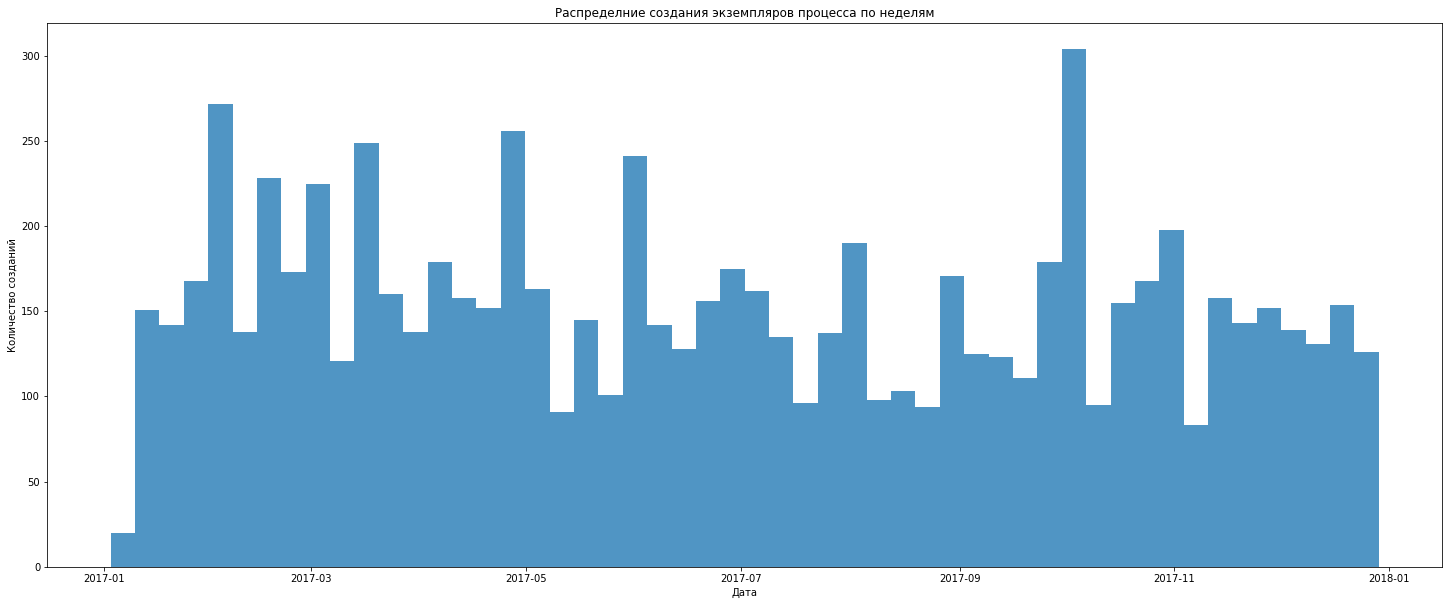

In [249]:
o_8 = O_8(df)

In [250]:
o_9 = O_9(df)

In [251]:
o_10 = O_10(df)

## Аномалии.

### Эффективность.

In [252]:
df = pd.read_csv('Event_log.txt', sep='\t', encoding='cp1251')

In [253]:
def eff_anomaly_detection(df):
    cases = df['CaseID'].unique()
    classes = df['Activity Class'].unique()
    features = np.zeros((len(cases), len(classes)))

    for i in range(len(cases)):
        chain = df[df['CaseID'] == cases[i]]    
        chain_count = chain.groupby('Activity Class')['Activity'].value_counts()
        for j in range(len(classes)):
            if classes[j] in chain_count:
                features[i][j] = chain_count[classes[j]].sum()
            
    mean_values = np.zeros(len(classes))

    tran_feat = features.T

    for i in range(len(classes)):
        mean_values[i] = tran_feat[i].mean()
    
    fin_dict = dict(zip(classes, mean_values))

    anomaly = np.zeros((len(cases), len(classes)))

    for j in range(len(classes)):
        anomaly[np.where(tran_feat[j] > mean_values[j] + 2 * tran_feat[j].std())[0]] = 1
    
    amount = len(np.unique(np.where(anomaly == 1)[0]))
    
    return amount, amount / len(cases)

In [254]:
eff_anomaly_amount, eff_anomaly_proc = eff_anomaly_detection(df)

In [255]:
# Данная функция вычисляет сколько раз пользователь нарушил разграничение обязанностей в кейсе
def find_quantity_of_violations(incomp_events, activ):
    num_of_violations = 0
    
    # ищем как часто встречались разные типы событий в списке
    sorted_col = Counter(activ)
    
    # если несовместимое событие имеется в коллекции sorted_col то счётчик num_of_violations увеличится на количество
    # случаев, когда пользователь выполнял несовместимое событие, если же событие отсутствует то к счётчику прибавиться 0
    for i in range(len(incomp_events)):
        num_of_violations += sorted_col[incomp_events[i]]
    return num_of_violations
def SOD_anomalies(df):

    # запоминаем название события в incomp_event и соответствующие ему несовместимые события в incomp_with
    incomp_event1 = 'Заказ на поставку создан'
    incomp_event2 = 'Создание Заявки'
    incomp_event3 = 'Требование авансового платежа-Возврат'
    incomp_event4 = 'Счет заведен'
    incomp_with1 = ['Заказ на поставку согласован 1', 'Заказ на поставку согласован 2', 'Платеж (выравнивание)', 
                    'Заказ на поставку блокирован', 
                    'Заказ на поставку: изменен статус выпуска: ДанныеОтпр, возможны изменения',
                    'Заказ на поставку: изменен статус выпуска: ДанныеСогл, измен не возможны', 
                    'Заказ на поставку: изменен статус выпуска: НачКод, возможны изменения', 
                    'Заказ на поставку: изменен статус выпуска: Согл, измен не возможны']
    incomp_with2 = ['Заявка согласована']
    incomp_with3 = ['Авансовый платеж', 'Перерасчет авансового платежа', 'Перерасчет авансового платежа-Возврат', 
                    'Перерасчет по требованию авансового платежа']
    incomp_with4 = ['Счет блокирован: несоответствие цены', 'Счет предварительно полностью зарегистрирован', 
                    'Счет блокирован: несоответствие даты', 
                    'Счет предварительно зарегистрирован']
    
    # группируем по идентификторам кейса, пользователям и событиям, которые выполняли пользователи в соответствующих кейсах
    arrcase = df.groupby(['CaseID', 'User'])['Activity'].apply(list)
    arrcase = arrcase.reset_index()
    
    # вспомогательные списки и переменные
    users_violations_track = []
    users = arrcase['User'].unique()
    users = list(users)
    violations = 0
    total_violations = 0
    
    # первый элемент списка users_violations_track это идентификатор пользователя, а второй количество его нарушений
    for i in range(len(users)):
        users_violations_track.append([users[i], 0])
        
    # ищем нарушения разграничений обязанностей
    for i in range(len(arrcase['User'])):
        # находим индекс пользователя в нашем списке пользователей
        user_index = users.index(arrcase['User'][i])
        
        # проверяем выполнял ли пользователь событие, у которого есть список несовместимых событий, затем проверяем
        # на наличие нарушений
        if(incomp_event1 in arrcase['Activity'][i]):
            
            # находим количество нарушений в текущем кейсе
            violations = find_quantity_of_violations(incomp_with1, arrcase['Activity'][i])
            
            # увеличиваем счётчик нарушений для текущего пользователя и то же самое делаем для счётчика общего
            # количества нарушений
            users_violations_track[user_index][1] += violations
            total_violations += violations
        if(incomp_event2 in arrcase['Activity'][i]):
            violations = find_quantity_of_violations(incomp_with2, arrcase['Activity'][i])
            users_violations_track[user_index][1] += violations
            total_violations += violations
        if(incomp_event3 in arrcase['Activity'][i]):
            violations = find_quantity_of_violations(incomp_with3, arrcase['Activity'][i])
            users_violations_track[user_index][1] += violations
            total_violations += violations 
        if(incomp_event4 in arrcase['Activity'][i]):
            violations = find_quantity_of_violations(incomp_with4, arrcase['Activity'][i])
            users_violations_track[user_index][1] += violations
            total_violations += violations
            
    # сортируем пользовтелей в порядке убывания количества нарушений
    users_violations_track = sorted(users_violations_track, key = lambda x: x[1], reverse = True)
    
    # отсекаем пользователей, у которых нету нарушений
    users_violations_track = list(filter(lambda x: x[1] != 0, users_violations_track))
    
    # возвращаем список, первым элементом которого является отсортированный список пользователей нарушивших
    # разграничение обязанностей, а второй элемент это общее количество нарушений разграничения обязанностей
    return [users_violations_track, total_violations]

In [256]:
SOD = SOD_anomalies(df)

In [257]:
d, eq_chains, num_cases =  unique_paths(df)

In [258]:
sorted_d = sorted(d.items(), key=lambda kv: kv[1], reverse=True)
sorted_d[:5]

[(58, 176), (246, 79), (299, 70), (734, 70), (54, 68)]

In [259]:
annex_1 = [[eq_chains[i[0]], i[1]] for i in sorted_d[:5]]

In [271]:
#Выявления цепочек с аномальным временем выполнения
def duration_anomaly(df):
    #Подготовка данных к обработке
    df = pd.read_csv('Event_log.txt', sep='\t', encoding='cp1251')
    df['Event end'] = pd.to_datetime(df['Event end'])
    df = df.sort_values(by='Event end')

    #Обработка данных: отбор закрытых кейсов
    started_cases = set(df.iloc[np.where(df['Activity Category'] == 'Заказ на поставку создан')]['CaseID'])
    finished_cases = set(df.iloc[np.where(df['Activity Category'] == 'Платеж (выравнивание)')]['CaseID'])
    finished = started_cases & finished_cases
    df['finished'] = df['CaseID'].apply(lambda x: x in finished)
    df = df[df['finished'] == 1]

    #Обработка данных: группировка событий в кейсы
    cases = df.groupby(['CaseID'])['Activity'].apply(lambda x: x.sum())
    cases = cases.reset_index()
    casesun = cases.drop_duplicates(subset=['Activity'])
    finished_cases
    casesun['Newcount']=casesun['Activity'].map(cases['Activity'].value_counts())
    arrcase = df.groupby(['CaseID'])['Activity'].apply(list)
    times = df.groupby(['CaseID'])['Event end'].apply(list)

    #Анализ данных: вычисление длительности каждого события
    def event_dur(arr):
        return np.array(arr[1:]) -  np.array(arr[:-1])
    durs = times.apply(lambda x: event_dur(x))
    for i in durs.index:
        for j in range(len(durs[i])):
            durs[i][j] = durs[i][j].total_seconds()
    case_durs = durs.reset_index()

    #Анализ данных: вычисление средней длительности события для каждого кейса
    case_durs['average'] = case_durs['Event end'].apply(lambda x: np.mean(x))

    #Анализ данных: вычисление средней длительности события для всех кейсов
    aver = np.mean(case_durs['average'])
    standard = np.std(case_durs['average'])

    #Идентификация аномальный кейсов
    case_durs['anomaly'] = case_durs['average']  > (aver + standard)



    #Вывод результата
    def ConvertSectoDay(n): 
  
        day = n // (24 * 3600) 
  
        n = n % (24 * 3600) 
        hour = n // 3600
  
        n %= 3600
        minutes = n // 60
  
        n %= 60
        seconds = n 
      
        return int(day), int(hour), int(minutes), int(seconds)
    plt.hist(case_durs['average'][case_durs['anomaly'] == True], bins=20, alpha=0.78, range=[1, max(case_durs['average'])])
    plt.grid()
    plt.ylabel('Number of cases')
    plt.xlabel('Average time of activity in the process path')
    #print('Количество кейсов, в которых выявлены аномалии: ' + str(sum(case_durs['average']  > (aver + standard))))
    #res = ConvertSectoDay(aver + standard)
    #print('Средняя  длительность события для всех кейсов: ' + str(res[0]) + ' дней ' + str(res[1]) + ' часов ' + str(res[2]) + ' минут ' + str(res[3]) + ' секунд')
    #print('Отношение кейсов, в которых выявлены аномалии, к общему числу всех кейсов: ' + str(int(100 * round(sum(case_durs['average']  > (aver + standard))/len(cases), 2))) + '%')
    plt.savefig('gist.png')
    
    return sum(case_durs['average']  > (aver + standard)), int(100 * round(sum(case_durs['average']  > (aver + standard))/len(cases), 2))


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


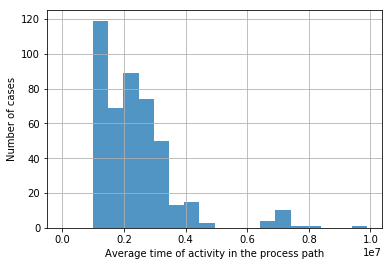

In [272]:
time_anomaly = duration_anomaly(df)

## Формирование отчета

In [319]:
import time
from reportlab.pdfbase.pdfmetrics import stringWidth
from reportlab.rl_config import defaultPageSize
from reportlab.platypus import PageBreak
from reportlab.lib.enums import TA_JUSTIFY
from reportlab.lib.pagesizes import letter, A4
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch, cm
from reportlab.platypus.tables import Table, TableStyle
from reportlab.pdfgen import canvas
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase import ttfonts
from reportlab.lib.colors import Color
from reportlab.lib import colors

def set_table_style(table):
    table.setStyle(TableStyle([
               ('ALIGN',(0,0),(-1,-1),'CENTER'),
               ('INNERGRID', (0,0), (-1,-1), 0.25, colors.black),
               ('BOX', (0,0), (-1,-1), 0.25, colors.black),
             ]))
    return table

def set_table_style1(table):
    table.setStyle(TableStyle([
               ('ALIGN',(1,1),(-1,-1),'CENTER'),
               ('INNERGRID', (0,0), (-1,-1), 0.25, colors.black),
               ('BOX', (0,0), (-1,-1), 0.25, colors.black),
             ]))
    return table

MyFontObject = ttfonts.TTFont('Arial', 'arial.ttf')
pdfmetrics.registerFont(MyFontObject)

doc = SimpleDocTemplate("Overview.pdf", pagesize=A4,
                        rightMargin=72, leftMargin=72,
                        topMargin=72, bottomMargin=18)

p1 = ParagraphStyle(name = 'Title',
                    fontSize = 24,
                    fontName='Helvetica-Bold',
                    leftIndent = 85,
                  )

VisualizationStyle = ParagraphStyle(name = 'Title',
                    fontSize = 20,
                    fontName='Helvetica-Bold',
                    leftIndent = 40,
                  )

GeneralKPIStyle = ParagraphStyle(name = 'Title',
                    fontSize = 20,
                    fontName='Helvetica-Bold',
                    leftIndent = 60,
                  )

AnomalyStyle = ParagraphStyle(name = 'Title',
                    fontSize = 20,
                    fontName='Helvetica-Bold',
                    leftIndent = 140,
                  )

AnnexStyle = ParagraphStyle(name = 'Title',
                    fontSize = 20,
                    fontName='Helvetica-Bold',
                    leftIndent = 200,
                  )

PKPIStyle = ParagraphStyle(name = 'Title',
                    fontSize = 20,
                    fontName='Helvetica-Bold',
                    leftIndent = 80,
                  )

p2 = ParagraphStyle(name = 'Title',
                    fontSize = 12,
                    fontName='Arial',
                    leftIndent = 20,
                  )


p4 = ParagraphStyle(name = 'Title',
                    fontSize = 12,
                    fontName='Arial',
                    leftIndent = 20,
                    leading = 20
                  )

p5 = ParagraphStyle(name = 'Title',
                    fontSize = 12,
                    fontName='Arial',
                    leftIndent = 20,
                    leading = 20
                  )

p6 = ParagraphStyle(name = 'Title',
                    fontSize = 12,
                    fontName='Arial',
                    leftIndent = 20,
                    leading = 15
                  )

Story = []

proc = 18
symb = '%'


formatted_time = time.ctime()

#styles = getSampleStyleSheet()
#styles.add(ParagraphStyle(name='small', fontsize=100))

ptext = 'Business process report' 
Story.append(Paragraph(ptext, p1))
Story.append(Spacer(1, 35))


ptext = '1 Visualization of the business process' 
Story.append(Paragraph(ptext, VisualizationStyle))
Story.append(Spacer(1, 12))

ptext = 'Detail percent of the visualization: %d %s' % (proc, symb)
Story.append(Paragraph(ptext, p2))
Story.append(Spacer(1, 12))

'''
im = Image('graphimage.png', 16*cm, 21*cm) # width height
#Story.append(Spacer(1, 120))
Story.append(Spacer(1, 6))
Story.append(im)
'''


im = Image('g.png', 7*inch, 8*inch) # width height
Story.append(Spacer(1, 40))
Story.append(im)

Story.append(PageBreak())

ptext = ' 2 General Key Performance Indicators' 
Story.append(Paragraph(ptext, GeneralKPIStyle))
Story.append(Spacer(1, 12))

ptext = ' \
    <br/> 1.  Number of cases: %d <br />\
    <br/> 2.  Number of unique process paths: %d <br />\
    <br/> 3.  Number of unique users: %d <br />\
    <br/> 4.  Number of completed process paths: %d <br/>\
    <br/>     Ratio of completed process paths: %f <br />\
    <br/> 5.  Number of deviant cases based on duration: %d <br />\
    <br/>     Ration of deviant cases to total number of casess: %f <br />\
    <br/> 6.  Complicated process paths: %d <br />\
    <br/> 7.  Average number of loops per process path: %d <br />\
    <br/> 8.  Average number of cases created per day: %d <br />\
    <br/> 9.  Most popular event categories  within a business process. <br />\
    <br/> <br />' % (o_1, o_2, o_3, o_4[0], o_4[1], o_5[0], o_5[1], o_6, o_7, o_8)
Story.append(Paragraph(ptext, p2))
t_1 = Table(o_9[0])
set_table_style(t_1)
Story.append(t_1)
Story.append(Spacer(1, 25))


t_2 = Table(o_9[1])
set_table_style(t_2)
Story.append(t_2)

ptext = '<br/> 10. Total time spent within each event class: <br />'
    
Story.append(Paragraph(ptext, p4))
t_3 = Table(o_10)
set_table_style(t_3)
Story.append(t_3)
Story.append(Spacer(1, 35))

Story.append(PageBreak())

ptext = '3 P2P Key Performance Indicators' 
Story.append(Paragraph(ptext, PKPIStyle))
Story.append(Spacer(1, 12))

ptext = '\
    <br/> 1.  Procurement volume: %d <br />\
    <br/> 2.  Ratio between number of goods and services: %f <br />\
    <br/> 3.  Ratio between expenditure on goods and expenditure on services: %f <br />\
    <br/> 4.  Domestic orders: %d <br />\
    <br/> 5.  Number of incomplete deliveries: %d <br />\
    <br/> 6.  Average time spent to confirm an order: %s <br />\
    <br/>     Percent of cases without approval: %d %s <br />\
    <br/>     Percent of approved cases: %d %s <br />\
    <br/> 7.  Average number of changes applied to an order: %f <br />\
    <br/>     Number of cases, in which there was at least one change applied to Purcahse Order: %d <br />\
    <br/> 8.  High risk suppliers: %d <br />\
    <br/> 9.  Number of orders carried out by high risk suppliers: %d <br />\
    <br/> 10. Expenses of returns:  %d <br />\
    ' % (p2p_1, p2p_2, p2p_3, p2p_4, p2p_5, p2p_6[0], p2p_6[1], symb, p2p_6[2], symb, p2p_7[0], p2p_7[1]
         ,p2p_8, p2p_9, p2p_10)
Story.append(Paragraph(ptext, p2))
Story.append(Spacer(1, 35))

Story.append(PageBreak())

ptext = '4 Anomaly analysis' 
Story.append(Paragraph(ptext, AnomalyStyle))
Story.append(Spacer(1, 12))

ptext = ' \
    <br/> 1.  Number of times Segregation of Duties policies have been violated: %d <br />\
    <br/> 2.  Number of cases with abnormal run-time: % d <br />\
    <br/>     Percent of cases with abnormal run-time: %d %s <br/>\
    <br/> 3.  Number of ineffective cases: %d  <br />\
' % (SOD[1], time_anomaly[0], time_anomaly[1], symb, eff_anomaly_amount) #, eff_anomaly_proc, symb)
Story.append(Paragraph(ptext, p6))

ptext =  ' \
    <br/>     Percent of ineffective cases: %d %s <br />\
' % (int(eff_anomaly_proc * 100), symb)

Story.append(Paragraph(ptext, p5))

im = Image('gist.png', 5*inch, 3*inch)
Story.append(im)
Story.append(Spacer(1, 12))

Story.append(Spacer(1, 35))

Story.append(PageBreak())

ptext = '5 Annex' 
Story.append(Paragraph(ptext, AnnexStyle))
Story.append(Spacer(1, 12))

ptext = ' 1. Five most frequent process paths: ' 

Story.append(Paragraph(ptext, p2))
Story.append(Spacer(1, 35))

data_1 = []

for row in annex_1:
    s = '->'.join(row[0])
    par = Paragraph(s, p2)
    data_1.append([par, row[1]])
    
t_4 = Table(data_1)
set_table_style(t_4)
Story.append(t_4)
Story.append(Spacer(1, 35))


ptext = '2.  Users, who have infringed Segregation of Duties policies most often:' 

Story.append(Paragraph(ptext, p2))
Story.append(Spacer(1, 35))

t_5 = Table(SOD[0])
set_table_style1(t_5)
Story.append(t_5)
Story.append(Spacer(1, 35))

doc.build(Story)

In [315]:
p2p_3

2.864576529450934

In [264]:
int(eff_anomaly_proc * 100)

20

In [265]:
eff_anomaly_proc

0.20809968847352026